# Prever candles 30M EURUSD

In [20]:
import os
import json
import time
import math
import pandas as pd
import matplotlib.pyplot as plt
from core.model import Model
from core.data_processor import *
import numpy as np
import matplotlib.pyplot as plt

## Configs

In [2]:
model_path = 'saved_models/lstm-EURUSD-30M-seq1000-output-ohlc-ep100-30042020-012133-e100.h5'
normalise = True
seq_len = 1000
cols = ["Close","Open","High","Low"]

df_2017 = pd.read_csv('data/EURUSD-2017_01_01-2017_12_31.csv')
df_2018 = pd.read_csv('data/EURUSD-2018_01_01-2018_12_31.csv')

## Carregar model

In [3]:
model = Model()
model.load_model(model_path)
model.model.summary()


[Model] Loading model from file saved_models/lstm-EURUSD-30M-seq1000-output-ohlc-ep100-30042020-012133-e100.h5
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 999, 50)           11000     
_________________________________________________________________
dropout (Dropout)            (None, 999, 50)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense (Dense)                (None, 4)                 204       
Total params: 31,404
Trainable params: 31,404
Non-trainable p

## Preparandos dados

### 2017

In [14]:
data_test = df_2017.get(cols).values
len_test   = len(data_test)

In [15]:
x_test_2017, y_test_2017, closes_2017 =  get_test_data(data_test, len_test, seq_len, normalise, debug=True)

100%|██████████| 10338/10338 [00:24<00:00, 429.93it/s]


In [16]:
x_test_2017.shape,y_test_2017.shape

((10338, 999, 4), (10338, 4))

### 2018

In [17]:
data_test = df_2018.get(cols).values
len_test   = len(data_test)

In [18]:
x_test_2018, y_test_2018, closes_2018 =  get_test_data(data_test, len_test, seq_len, normalise, debug=True)

100%|██████████| 10967/10967 [00:26<00:00, 418.39it/s]


In [19]:
x_test_2018.shape,y_test_2018.shape

((10967, 999, 4), (10967, 4))

## Preços

Preços de fechamento

### 2017

AttributeError: 'AxesSubplot' object has no attribute 'subtitle'

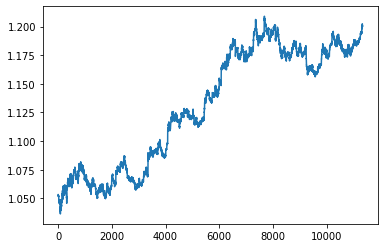

In [29]:
N = 100

# 2017
fig1 = plt.figure(facecolor='white')
# plt.title("2017")
ax1 = fig1.add_subplot(111)
rolling_mean1 = pd.Series(df_2017["Close"]).rolling(window=N).mean().iloc[N-1:].values
l = len(rolling_mean1)
for i in range(l, len(df_2017["Close"].values)):
    rolling_mean1 = np.insert(rolling_mean1, 0, rolling_mean1[0], axis=0)
ax1.plot(df_2017["Close"], label='Close')
ax1.suptitle('test title', fontsize=20)
plt.plot(rolling_mean1, label='Média móvel')
plt.legend()
plt.show()

# 2018
fig1 = plt.figure(facecolor='white')
plt.title("2018")
ax1 = fig1.add_subplot(111)
rolling_mean1 = pd.Series(df_2018["Close"]).rolling(window=N).mean().iloc[N-1:].values
l = len(rolling_mean1)
for i in range(l, len(df_2018["Close"].values)):
    rolling_mean1 = np.insert(rolling_mean1, 0, rolling_mean1[0], axis=0)
ax1.plot(df_2018["Close"], label='Close')
plt.plot(rolling_mean1, label='Média móvel')
plt.legend()
plt.show()

### 2018